# Bayesian Marketing Analysis
## Predicting marketing ROI

In this simplified project I will be simulating a company's advertising spending and customer value in order to quantify the impact of a marketing campaign. It is based off ideas and examples given at talk of [Thomas Wieki at the PyData Conference in London, 2022](https://www.youtube.com/watch?v=twpZhNqVExc&t=973s). I combined these ideas with the Bayesian Astronomy workshop by Jake Vanderplas [here](https://github.com/jakevdp/BayesianAstronomy/tree/3e83b466515df450dc7886109b6f444b55bf0238).

The question that I am trying to answer is: How much marketing money does the company have to spend in order to aquire a single customer. This will be quantified using the customer aquisition cost (CAC) and the customer lifetime value (CLV). So the company would want a CAC $<$ CLV

Using the following Bayesian statistical techniques, the company will be able to make informed decisions from quantitative results. For example, I quantify the likeliness that an advertising campaign would be profitable. While this project is simplified, it is meant to by a proof of concept for Bayesian inference and could be improved upon if necessary (especially with the addition of more domain knowledge).


### Assumptions

- CLV $= \$ 630$
- There exists an underlying model relating marketing spend to customer value. I will assume an underlying model that is an S-Shaped Response Curve (Logistic Growth Model).
- There is only one advertising channel (for simplicity)
- The data is simulated based off of numbers from the Thomas Wieki talk.
- errors are homoscedastic




### The model

We will be using this model to predict the number of new customers resulting from an ad campaign.
$$ y(x) = A+\frac{L}{1+e^{-k(x-x_0)}}$$

where parameter vector is,

$$ \theta = [A,L,k,x_0]$$

Note that we are doing Bayesian statistics so the end goal is to find the posterior probability distribution, $$P(\theta \mid D) = \frac{P(D\mid\theta)P(\theta)}{P(D)}.$$ Therefore, we need to know the prior and the likelihood (we can ignore the fully marginalized likelihood). 

First let's think about the likelihood probability distributions next, $P(D|\theta)$. We assumed that the probability for any single data point is a normal distribution about the true value. So,

$$
y_i \sim \mathcal{N}(y_M(x_i;\theta), \sigma)
$$

or, in other words,

$$
P(x_i,y_i\mid\theta) = \frac{1}{\sqrt{2\pi\varepsilon_i^2}} \exp\left(\frac{-\left[y_i - y_M(x_i;\theta)\right]^2}{2\varepsilon_i^2}\right)
$$
This reads as "the probability of data point $(x_i,y_i)$ given model parameter vector, $\theta$"
We will assume that $\epsilon_i$ is known and measured.

The full log-likelihood is,

$$
\log P(D\mid\theta) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\varepsilon_i^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\varepsilon_i^2}\right)
$$

In [515]:
# !pip install emcee

In [516]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [659]:
def make_data(A,L,logk,x0,N=40,dy=70,rseed=42):
    #Logistic Growth Model with noise added
    rand = np.random.RandomState(rseed)
    x = 1000 * rand.rand(N)
    k = 10**logk
    z = k * (x - x0)
    # Use a stable implementation of the logistic function
    if np.any(z > 0):
        y = A + L / (1 + np.exp(-z))
    else:
        exp_z = np.exp(z)
        y = A + L * exp_z / (1 + exp_z)
    # y = A + L/(1+np.exp(-k*(x-x0)))
    y += dy * rand.randn(N)
    return x,y,dy*np.ones_like(x)

In [660]:
# ad_spend_range = [50,700] #millions of dollars
# # new_customers = [10,175] #thousands of customers
# ad_spend = np.linspace(*ad_spend_range,N)
# new_cust = np.linspace(*new_customers,50)
theta_true = [100, 1000 ,-1.9, 300] #these are the parameters we are trying to uncover
x,y,dy = make_data(*theta_true)

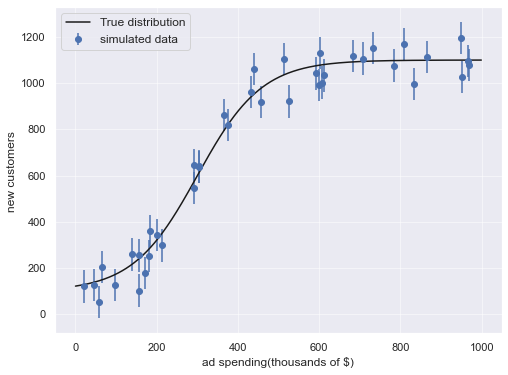

In [661]:
fig, ax = plt.subplots(1,figsize=(8,6))
ax.errorbar(x, y, dy,fmt='o',label='simulated data')
ax.set_xlabel("ad spending(thousands of $)",fontsize=12)
ax.set_ylabel("new customers ",fontsize=12)
ax.grid(alpha=0.5)

x_fine = np.arange(0,1000,1)
ax.plot(x_fine,model(theta_true,x_fine),color='k',label='True distribution')
ax.legend(loc='upper left',fontsize=12)

In [662]:
def model(theta, x):
    A,L,logk,x0 = theta
    # k = 10**logk
    # return A + L/(1+np.exp(-k*(x-x0)))
    k = 10**logk
    z = k * (x - x0)
    # Use a stable implementation of the logistic function
    if np.any(z > 0):
        y = A + L / (1 + np.exp(-z))
    else:
        exp_z = np.exp(z)
        y = A + L * exp_z / (1 + exp_z)
    return y
def log_likelihood(theta, x, y, dy):
    #y_model = theta[0] + theta[1] * x
    y_model= model(theta,x)
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) +
                         (y - y_model) ** 2 / dy ** 2)
def log_prior(theta):
    # flat prior: log(1) = 0
    return 0

def log_posterior(theta, x, y, dy):
    return log_prior(theta) + log_likelihood(theta, x, y, dy)

In [663]:
import emcee

In [664]:
ndim = 4  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers

#[100, 1000 ,-1.9, 300]
guess_means = [120,900,-2,320]
guess_stds = [30,100,0.1,30]
starting_guesses = np.random.randn(nwalkers, ndim)
for i in range(ndim):
    starting_guesses[:,i] = starting_guesses[:,i]*guess_stds[i]+guess_means[i]
# starting_guesses[:,0]=starting_guesses[:,0]+10
# starting_guesses[:,1]=starting_guesses[:,1]+100
# starting_guesses[:,2]=starting_guesses[:,2]+(-1)
# starting_guesses[:,3]=starting_guesses[:,3]+200

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,
                                args=[x, y, dy])
pos, prob, state = sampler.run_mcmc(starting_guesses, 200) 

In [665]:
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

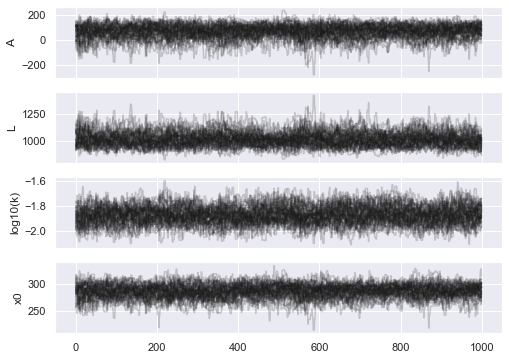

In [666]:
fig, ax = plt.subplots(4, sharex=True,figsize=(8,6))
labels = ["A","L","log10(k)","x0"]
theta_best = []
theta_std = []
for i in range(4):
    chain_data = sampler.chain[:, :, i].T
    ax[i].plot(chain_data, '-k', alpha=0.2)   
    ax[i].set_ylabel(labels[i],fontsize=12)
    theta_best.append(chain_data.mean())
    theta_std.append(chain_data.std())

In [667]:
# pip install corner

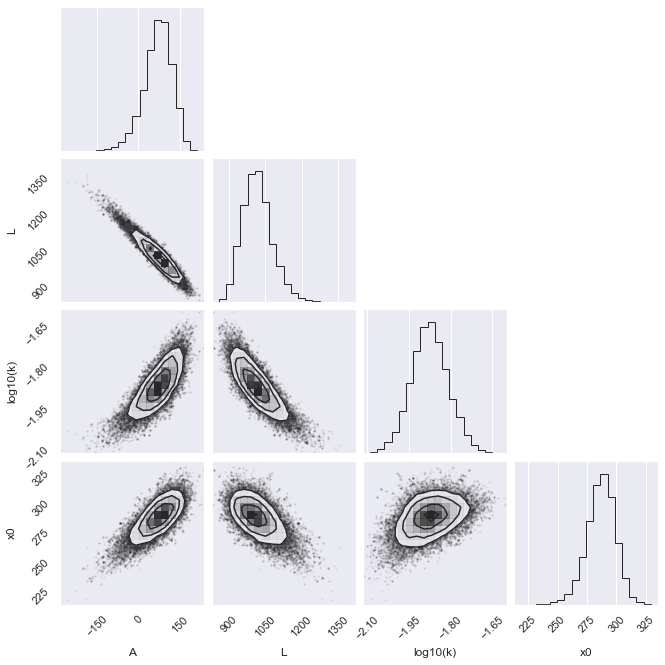

In [668]:
import corner
corner.corner(sampler.flatchain, labels=labels);

In [669]:
print("Best Estimates")
for i in range(4):
    print(f"{labels[i]} = {theta_best[i]:.2f} +/- {theta_std[i]:.2f}")

print("\nTrue values")
for i in range(4):
    print(f"{labels[i]} = {theta_true[i]:.2f}")

Best Estimates
A = 68.77 +/- 52.07
L = 1018.44 +/- 61.35
log10(k) = -1.88 +/- 0.07
x0 = 286.74 +/- 12.19

True values
A = 100.00
L = 1000.00
log10(k) = -1.90
x0 = 300.00


In [749]:
theta_best, theta_std
parameter_preds = np.random.randn(500, ndim)
for i in range(ndim):
    parameter_preds[:,i] = parameter_preds[:,i]*theta_std[i]+theta_best[i]

In [750]:
f_pred = []
for i in range(500):
    f_pred.append(model(parameter_preds[i],xfit))

In [751]:
# plt.scatter(np.array(f_pred))
mean_pred = np.mean(np.array(f_pred),axis=0)
std_pred  = np.std(np.array(f_pred),axis=0)

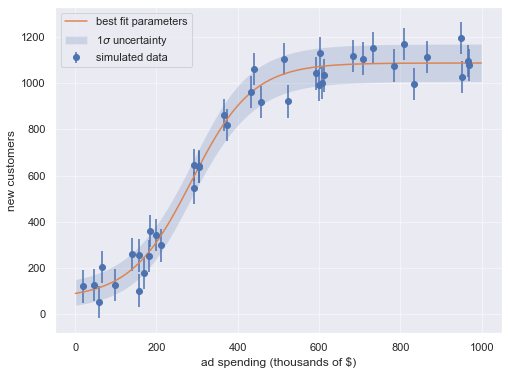

In [761]:
fig, ax = plt.subplots(1,figsize=(8,6))
ax.errorbar(x, y, dy,fmt='o',label='simulated data')
ax.set_xlabel("ad spending (thousands of $)",fontsize=12)
ax.set_ylabel("new customers",fontsize=12)
ax.grid(alpha=0.5)

xfit = np.arange(1,1000)
yfit = model(theta_best, xfit)
ax.plot(xfit,yfit,label='best fit parameters')
# ax.scatter(xfit,mean_pred,label='')
ax.fill_between(xfit, mean_pred-std_pred, mean_pred+std_pred,alpha=0.2,label=r'1$\sigma$ uncertainty')
ax.legend()
# samples_z = np.random.normal(3, 0.5, 1000) 


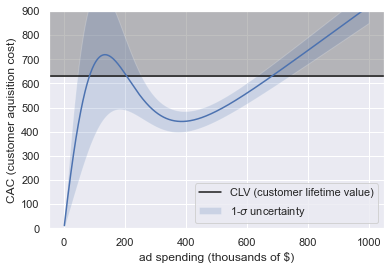

In [811]:
# plt.plot((yfit)/xfit)
# plt.ylim(0,5000)
# plt
CAC = (xfit*1000/yfit)
delta_CAC = xfit*1000*yfit**(-2)*std_pred #propagating uncertainty
plt.axhline(630,label="CLV (customer lifetime value)",color='k')
plt.axhspan(630,900,alpha=0.5,color='gray')
plt.plot(xfit,CAC)
plt.fill_between(xfit, CAC-delta_CAC, CAC+delta_CAC,alpha=0.2,label=r'1-$\sigma$ uncertainty')
plt.ylabel("CAC (customer aquisition cost)")
plt.xlabel("ad spending (thousands of $)")
plt.ylim(0,900)
plt.legend()

In [812]:
z_score = (630-CAC[249])/delta_CAC[249]
probability_below_CLV = stats.norm.cdf(z_score)

### Given that the underlying model is correct, we can make useful statistical statements to inform the company's marketing decision.

In [813]:
print(f"There is a {probability_below_CLV*100:.2f}% chance that an {xfit[249]} "
      "thousand dollar advertising campaign will result in a CAC below the CLV.")

There is a 81.85% chance that an 250 thousand dollar advertising campaign will result in a CAC below the CLV.
